# Sparkify Project Model and Result
This workspace contains the code necessary to run the notebook on the full dataset available (12GB) deploying your cluster on the cloud. <br>

- 1. Load and Clean Dataset
- 2. Define the user dataframe with the features
- 3. Rescaling and assembling of features
- 4. Create and Train the models
- 5. Evaluation of the models
- 5. Summary and Conclusion

# Import libraries

In [1]:
# necessary if we use pyspark on a local machine
import findspark
findspark.init()


from pyspark import SparkContext, SparkConf

# data wrangling with dataframe
from pyspark.sql import SparkSession, SQLContext, Window
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import lit, udf, lower, col, isnan, when, count, countDistinct, datediff, dayofyear, lag, year, month, dayofmonth, concat
from pyspark.sql.types import StringType, IntegerType, StructType, TimestampType

# machine learning
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# other
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
.builder \
.appName("sparkify") \
.getOrCreate()

# 1. Load and Clean Dataset

In [3]:
# Load subset data localy.
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

In [226]:
# If you launch a cluster using AWS, here is the code to use to load the full dataset

# event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
# df = spark.read.json(event_data)

In [4]:
# in case that there is some missing values appearing in the big dataset we supress the rows with missing values in userId 
# or sessionId columns that does not correspond to actions made by users
df = df.dropna(subset=["userId", "sessionId"], how="any")

In [5]:
# The userId "" does not seem to correspond to the activity of an actual user. 
# We decide to suppress all the rows corresponding to this userId.
df = df.filter(df.userId != "")

In [6]:
def convert_unix_epoch(df, col_name):
    """
    Convert epoch timestamp to date.
        Args:
            df : spark dataframe (with column in unix epoch timestamps format)
            col_name(str) : column name to convert
        Output:
            df : spark dataframe (with column in a date timestamp format)
    """
    # convert unix epoch timestamps to second
    df = df.withColumn(col_name, col(col_name)/1000)
    # convert unix epoch timestamps into date timestamps
    df = df.withColumn(col_name, col(col_name).cast(TimestampType()))
    return df


# we convert the unix epoch timestamps into date timestamps ("ts" and "registration" columns of the spark dataframe)
df = convert_unix_epoch(df, "ts")
df = convert_unix_epoch(df, "registration")

# 2. Define the user dataframe with the features and the labels

In [7]:
# Define Churn

# flag event for churn
flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn_event", flag_cancellation_event("page"))

# labeling all the users actions who churned using an agregation with window function
window_val = Window.partitionBy('userId')
df = df.withColumn("churn", Fsum("churn_event").over(window_val))

In the following blocs, we define dataframes with UserId in one column and the feature that we want to have in the other. <br> We then join the dataframes together to get the users dataframe containing the labels of the users and their features.

In [8]:
def get_feature_df(df, page_name):
    """
    Get a dataframe with the userId in the first column and the count of the selected page_name for each user in the second 
    column.
    
        Args:
            df: Dataframe containing events for sparklify
            page_name (str): name of the page where we desire to have the number of count for each user
        Outputs:
            df_feature: dataframe with the userId in the first column and the value of the page_name for each user in the 
                        second column.
    """
    column_name = "n_" + str.lower(page_name).replace(" ", "_")
    df_feature = df.filter(df.page==page_name).groupby("userId").count().select("userId", col("count").alias(column_name))
    return df_feature

In [9]:
# pages counts dataframes
n_nextsong = get_feature_df(df, "NextSong")
n_home = get_feature_df(df, "Home")
n_add_friends = get_feature_df(df, "Add Friend")
n_roll_advert = get_feature_df(df, "Roll Advert")
n_thumbs_down = get_feature_df(df, "Thumbs Down")
n_about = get_feature_df(df, "About")
n_error = get_feature_df(df, "Error")

In [10]:
# churn is renamed label
churn = df.select("userId", "churn").groupby("userId").max().select("userId", col("max(churn)").alias("label"))

In [11]:
# Gender values are transformed in integers (0 : women, 1 : men)
gender_int = udf(lambda x: 1 if (x == "M") else 0, IntegerType())
gender = df.withColumn("gender", gender_int("gender"))\
           .select("UserId", "gender").distinct().groupby("userId").sum()\
           .select("userId", col("sum(gender)").alias("gender"))

In [12]:
# Level values are transformed in integers (0 : free, 1 : paid)
level_int = udf(lambda x: 1 if (x == "paid") else 0, IntegerType())
level = df.withColumn("level", level_int("level"))\
           .select("UserId", "level").distinct().groupby("userId").sum()\
           .select("userId", col("sum(level)").alias("level"))

In [13]:
# Average days difference between 2 successive connections dataframe

# remove the hours minute and second from the timestamps "ts"
df = df.withColumn("date", (concat(year(col("ts")), lit("-"), 
                                   month(col("ts")), lit("-"), 
                                   dayofmonth(col("ts")))\
                            .cast(TimestampType())))
# remove the duplicate
df_date = df.select("userId", "date").orderBy("date").distinct()

# calculation the mean difference between days of connection using a window function
w = Window().partitionBy("userId").orderBy("date")
df_date = df_date.withColumn("diff", -datediff(lag(col("date"), 1).over(w), "date"))\
    .groupBy("userId")\
    .mean()

# remname of the result column
df_date = df_date.select("userId", col("avg(diff)").alias("avg_conn_diff"))

In [14]:
# number of sessions 
n_sessions = df.select("userId", "sessionId").groupBy("userId").agg(countDistinct("sessionId"))
n_sessions = n_sessions.select("userId", col("count(DISTINCT sessionId)").alias("n_sessions"))

In [25]:
# join of all the dataframes to create users_df
users_df = n_nextsong.join(n_add_friends, on="userId", how='outer')\
                    .join(n_roll_advert, on="userId", how='outer')\
                    .join(n_about, on="userId", how='outer')\
                    .join(n_error, on="userId", how='outer')\
                    .join(n_thumbs_down, on="userId", how='outer')\
                    .join(gender, on="userId", how='outer')\
                    .join(level, on="userId", how='outer')\
                    .join(n_sessions, on="userId", how='outer')\
                    .join(df_date, on="userId", how='outer')\
                    .join(churn, on="userId", how='outer')\

In [29]:
# As the null values correspond to users that did not visit pages, we can replace the null values by zeros
users_df = users_df.na.fill(0)

In [27]:
# division of columns to optain the final features
users_df = users_df.withColumn("r_nextsong_session", col("n_nextsong") / col("n_sessions"))
users_df = users_df.withColumn("r_roll_advert_session", col("n_roll_advert") / col("n_sessions"))
users_df = users_df.withColumn("r_about_session", col("n_about") / col("n_sessions"))
users_df = users_df.withColumn("r_error_session", col("n_error") / col("n_sessions"))
users_df = users_df.withColumn("r_thumbs_down_song", col("n_thumbs_down") / col("n_nextsong"))
users_df = users_df.withColumn("r_nextsong_session", col("n_nextsong") / col("n_sessions"))

In [31]:
# suppression of columns that are not needed anymore
users_df = users_df.drop("n_nextsong", "n_roll_advert", "n_about", "n_error", "n_thumbs_down", "n_sessions")

In [32]:
# check of the remaining columns that correspond to features
# (we kept the userId to identify the users)
users_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- n_add_friend: long (nullable = true)
 |-- gender: long (nullable = true)
 |-- level: long (nullable = true)
 |-- avg_conn_diff: double (nullable = false)
 |-- label: long (nullable = true)
 |-- r_nextsong_session: double (nullable = false)
 |-- r_roll_advert_session: double (nullable = false)
 |-- r_about_session: double (nullable = false)
 |-- r_error_session: double (nullable = false)
 |-- r_thumbs_down_song: double (nullable = false)



# 3. Rescaling and assembling of features

We rescale each feature compare to the other values obtain by all the users for this feature. <br>
We then assemble the features of each user to a vector that will be used to create the machine learning pipelines for each model.

## Rescaling features

In [33]:
features_list = ["n_add_friend", "avg_conn_diff","r_nextsong_session", "r_roll_advert_session", "r_about_session",  
                 "r_error_session", "r_thumbs_down_song",]

# we rescale the non binary values of the features (all except gender and level)
for feature in features_list:
    print(feature +"... in progress")
    vector_assembler = VectorAssembler(inputCols=[feature], outputCol=feature+"_vector")
    min_max_scaler = MinMaxScaler(inputCol=feature+"_vector", outputCol=feature+"_scaled")
    pipeline = Pipeline(stages=[vector_assembler, min_max_scaler])

    # Fitting pipeline on dataframe
    scale_features = pipeline.fit(users_df)
    
    # we do the transformation on the dataframe
    users_df = scale_features.transform(users_df)
    users_df = users_df.drop(feature, feature+"_vector")
    print(feature +"... done")

n_add_friend... in progress
n_add_friend... done
avg_conn_diff... in progress
avg_conn_diff... done
r_nextsong_session... in progress
r_nextsong_session... done
r_roll_advert_session... in progress
r_roll_advert_session... done
r_about_session... in progress
r_about_session... done
r_error_session... in progress
r_error_session... done
r_thumbs_down_song... in progress
r_thumbs_down_song... done


## Assembling

We assemble the rescaled feature to a common vector that will be used to train the models.

In [34]:
# we add the binary features to the other rescaled features
features_list = [name + "_scaled" for name in features_list] + ["gender", "level"]

# we assemble the different features for each user in a vector
features_assembler = VectorAssembler(inputCols=features_list, outputCol="features")

# 4. Training

We split the dataframe in a train and test dataframe. <br>

We then try fitting the train data with different models :
- Logistic regression
- Decision tree classifier
- Random forest classifier
- Gradient-boosted tree classifier

We create a few functions to extract the hyperparameters used with gridSearch and the optained scores. <br>
Other functions are used to extract the coefficient / importance of the features used for the fitting. :
- get_parameters_name
- get_parameters_values
- get_df_model_eval
- plot_features_importance_classification
- plot_features_coeff

In [35]:
# we create 4 estimator pipelines corresponding to the 4 classifiers model that we want to test

lr = LogisticRegression(featuresCol="features", labelCol="label")
pipeline_lr = Pipeline(stages=[features_assembler, lr])

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
pipeline_dt = Pipeline(stages=[features_assembler, dt])

rf = RandomForestClassifier(labelCol="label", featuresCol="features")
pipeline_rf = Pipeline(stages=[features_assembler, rf])

gbt = GBTClassifier(labelCol="label", featuresCol="features")
pipeline_gbt = Pipeline(stages=[features_assembler, gbt])

In [36]:
# Train test split
train_df, test_df = users_df.randomSplit([0.8, 0.2], seed=42)

In [37]:
# we define the number of folds to put in the crossvalidation models
numFold_value = 5

In [38]:
# we check the balance between the number of users that churned and those who don't in the dataset
users_df.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [39]:
# Due to this imbalance in the dataset, we choose to use f1 metric as evaluator
# we create an evaluator and check if the metric used is indeed f1.
my_evaluator = MulticlassClassificationEvaluator()
my_evaluator.getMetricName()

'f1'

In [204]:
def get_parameters_name(paramGrid):
    """
    Get the name of the hyperparameters tuned in the grid search from a paramGrid object.
    
        Args:
            paramGrid: paramGrid defined in the crossvalidation of the model
            
        Outputs:
            param_names (list): list of the names of the hyperparameters tuned.
    """
    param_names = []
    for n in paramGrid[0].keys() :
        param_names.append((str(n).split("__")[1]))
    return param_names

In [205]:
def get_parameters_values(paramGrid):
    """
    Get the values of the hyperparameters tuned in the grid search.
    
        Args:
            paramGrid: paramGrid defined in the crossvalidation of the model
            
        Outputs:
            values_params (list): list of the values of the hyperparameters tuned.
    """
    values_params = []
    for n in range(len(paramGrid)):
        values_params.append(list(paramGrid[n].values()))
    return values_params

In [57]:
def get_df_model_eval(cv_model, paramGrid):
    """
    Get a dataframe with the name of the hyperparameters and their values and the corresponding score optain by crossvalidation.
    
        Args:
            cv_model: crossvalidation model
            paramGrid: paramGrid defined in the crossvalidation of the model
            
        Outputs:
            model_eval_df: dataframe with the name of the hyperparameters and their values and the corresponding score optain 
                           by crossvalidation.
    """
    model_eval_df = pd.DataFrame(get_parameters_values(paramGrid), columns = get_parameters_name(paramGrid)) 
    model_eval_df["score"] = cv_model.avgMetrics
    return model_eval_df

In [207]:
def plot_features_importance_classification(cv_model, features_list):
    """
    Plot the importance of features for classification model.
    
        Args :
            cv_model : cross validation model
            features_list : list of features used to fit the cross validation model
            
        Output:
            None
    """
    
    features_importance_dict = cv_model.bestModel.stages[-1].featureImportances
    features_importance_values = []
    k = 0
    x = range(len(features_list))
    for n in x:
        if n in features_importance_dict.indices:
            features_importance_values.append(features_importance_dict.values[k])
            k+=1
        else:
            features_importance_values.append(0)
    
    # plot
    fig, ax = plt.subplots()
    ax.barh(x, features_importance_values)
    ax.set_yticks(x)
    ax.set_yticklabels(features_list)
    ax.set_title("Features importance")
    return

In [214]:
def plot_features_coeff(cv_model, features_list):
    """
    Plot the coefficient values of features for logistic regression model.
    
        Args :
            cv_model : cross validation model
            
        Output:
            None
    """
    features_coeff = list(cv_model_lr .bestModel.stages[-1].coefficients)
    x = range(len(features_list))
    # plot
    fig, ax = plt.subplots()
    ax.barh(x, features_coeff)
    ax.set_yticks(x)
    ax.set_yticklabels(features_list)
    ax.set_title("Features coefficients")
    return

## Logistic regression

In [40]:
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.aggregationDepth, [2, 5, 10]) \
    .addGrid(lr.maxIter, [100, 200])\
    .addGrid(lr.regParam, [0.001, 0.005, 0.01])\
    .build()

crossval_lr = CrossValidator(estimator=pipeline_lr,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=my_evaluator, 
                             numFolds=numFold_value)

cv_model_lr = crossval_lr.fit(train_df)

In [58]:
df_lr_model_eval = get_df_model_eval(cv_model_lr, paramGrid_lr)
df_lr_model_eval.sort_values("score", ascending=False)

,aggregationDepth,maxIter,regParam,score
17,10,200,0.010,0.746443
2,2,100,0.010,0.746443
5,2,200,0.010,0.746443
8,5,100,0.010,0.746443
11,5,200,0.010,0.746443
14,10,100,0.010,0.746443
13,10,100,0.005,0.741321
16,10,200,0.005,0.741321
4,2,200,0.005,0.741321
7,5,100,0.005,0.741321


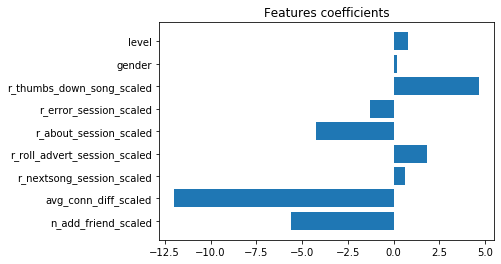

In [209]:
plot_features_coeff(cv_model_lr, features_list)

## Decision tree classifier

In [41]:
paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 5, 10]) \
    .addGrid(dt.impurity, ["gini", "entropy"]) \
    .build()

crossval_dt = CrossValidator(estimator=pipeline_dt,
                          estimatorParamMaps=paramGrid_dt,
                          evaluator=my_evaluator,
                          numFolds=numFold_value)

cv_model_dt = crossval_dt.fit(train_df)

In [59]:
df_dt_model_eval = get_df_model_eval(cv_model_dt, paramGrid_dt)
df_dt_model_eval.sort_values("score", ascending=False)

,maxDepth,impurity,score
0,2,gini,0.736756
1,2,entropy,0.726257
3,5,entropy,0.725269
5,10,entropy,0.725051
2,5,gini,0.719693
4,10,gini,0.711085


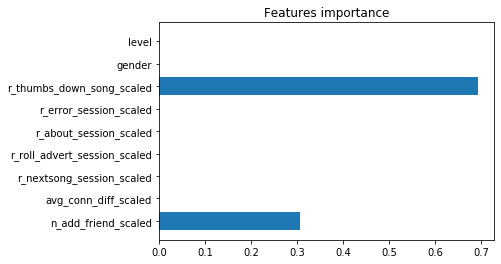

In [211]:
plot_features_importance_classification(cv_model_dt, features_list)

## Random forest classifier

In [42]:
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.impurity, ["gini", "entropy"]) \
    .addGrid(rf.numTrees, [5, 10, 20]) \
    .build()

crossval_rf = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=my_evaluator,
                          numFolds=numFold_value)

cv_model_rf = crossval_rf.fit(train_df)

In [60]:
df_rf_model_eval = get_df_model_eval(cv_model_rf, paramGrid_rf)
df_rf_model_eval.sort_values("score", ascending=False)

,maxDepth,impurity,numTrees,score
1,5,gini,10,0.752862
9,10,entropy,5,0.738682
3,5,entropy,5,0.735084
17,15,entropy,20,0.733334
15,15,entropy,5,0.732245
6,10,gini,5,0.731996
0,5,gini,5,0.731841
11,10,entropy,20,0.729460
12,15,gini,5,0.727648
7,10,gini,10,0.723468


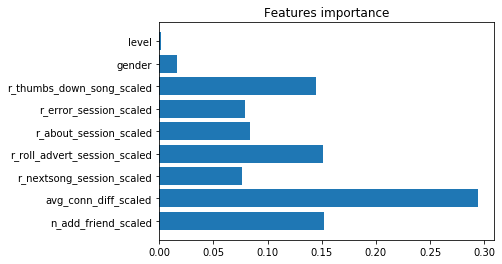

In [212]:
plot_features_importance_classification(cv_model_rf, features_list)

## Gradient-boosted tree classifier

In [44]:
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [2, 5, 10, 15]) \
    .addGrid(gbt.maxIter, [5, 10, 20]) \
    .build()

crossval_gbt = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=my_evaluator,
                          numFolds=numFold_value)

cv_model_gbt = crossval_gbt.fit(train_df)

In [61]:
df_gbt_model_eval = get_df_model_eval(cv_model_gbt, paramGrid_gbt)
df_gbt_model_eval.sort_values("score", ascending=False)

,maxDepth,maxIter,score
0,2,5,0.751575
2,2,20,0.736384
4,5,10,0.734716
5,5,20,0.734716
3,5,5,0.729507
1,2,10,0.719011
6,10,5,0.711085
7,10,10,0.711085
8,10,20,0.711085
9,15,5,0.711085


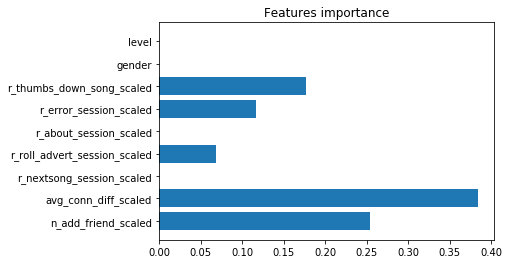

In [213]:
plot_features_importance_classification(cv_model_gbt, features_list)

# 5. Evaluation

We evaluate our models using the test dataset this time to see if the models perform well on data that hasn't been seen before.
We create a function to extract the confusion matrix and different metrics to evaluate the performance of the model on new data.

In [224]:
def get_metrics_result(result_model, model_name):
    """ 
    Get the confusion matrix from the result dataframe containing the labels and the predictions of a model.
    
        Args:
            result_model: pandas dataframe containing a label column and a prediction column
        Output:
            confusion matrix: pandas dataframe containng the confusion matrix of the result of the model
            evaluation_metrics :
                accuracy : Ratio of correctly predicted observation to the total observations.
                precision : Ratio of correctly predicted positive observations to the total predicted positive observations.
                recall : Ratio of correctly predicted positive observations to the all observations in actual class - churn.
                f1 : Weighted average of Precision and Recall.
    """
    # calculation of true negatives (label=0, prediction=0),
    #                true positives (label=1, prediction=1), 
    #                false_negative (label=1, prediction=0),
    #                false_positive (label=0, prediction=1)
    true_negative = result_model[(result_model["label"]==0) & (result_model["prediction"]==0)]["label"].count()
    true_positive = result_model[(result_model["label"]==1) & (result_model["prediction"]==1)]["label"].count()
    false_negative =  result_model[(result_model["label"]==1) & (result_model["prediction"]==0)]["label"].count()
    false_positive =  result_model[(result_model["label"]==0) & (result_model["prediction"]==1)]["label"].count()
    
    # get the confusion matrix
    confusion_matrix = pd.DataFrame([[true_negative, false_positive], [false_negative, true_positive]],  
                                    columns = ["no churn", "churn"], index=["no churn", "churn"]) 
    
    # calculate accuracy, precision, recall and f1 metrics
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_negative + false_positive)
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1 = 2 * precision * recall / (precision + recall)
    
    evaluation_metrics = pd.DataFrame([[accuracy, precision, recall, f1]], 
                                      columns=["accuracy", "precision", "recall", "f1"], index=[model_name])

    return confusion_matrix, evaluation_metrics

 ## Logistic Rgeression

In [46]:
test_lr = cv_model_lr.transform(test_df)
test_lr = test_lr.select("label", "prediction")
predict_lr_pd = test_lr.toPandas()

In [225]:
confusion_matrix_lr, evaluation_metrics_lr = get_metrics_result(predict_lr_pd, "Logistic Regression Classifier")
print(confusion_matrix_lr)
print(evaluation_metrics_lr)

          no churn  churn
no churn        24      2
churn            6      2
                                accuracy  precision  recall        f1
Logistic Regression Classifier  0.764706        0.5    0.25  0.333333


## Decision Tree Classifier

In [47]:
test_dt = cv_model_dt.transform(test_df)
test_dt = test_dt.select("label", "prediction")
predict_dt_pd = test_dt.toPandas()

In [219]:
confusion_matrix_dt, evaluation_metrics_dt = get_metrics_result(predict_dt_pd, "Decision Tree Classifier")
print(confusion_matrix_dt)
print(evaluation_metrics_dt)

          no churn  churn
no churn        23      3
churn            3      5
                          accuracy  precision  recall     f1
Decision Tree Classifier  0.823529      0.625   0.625  0.625


## Random Forrest Classifier

In [48]:
test_rf = cv_model_rf.transform(test_df)
test_rf = test_rf.select("label", "prediction")
predict_rf_pd = test_rf.toPandas()

In [220]:
confusion_matrix_rf, evaluation_metrics_rf = get_metrics_result(predict_rf_pd, "Random Forest Classifier")
print(confusion_matrix_rf)
print(evaluation_metrics_rf)

          no churn  churn
no churn        26      0
churn            7      1
                          accuracy  precision  recall        f1
Random Forest Classifier  0.794118        1.0   0.125  0.222222


## Gradient-boosted Tree Classifier

In [49]:
test_gbt = cv_model_gbt.transform(test_df)
test_gbt = test_gbt.select("label", "prediction")
predict_gbt_pd = test_gbt.toPandas()

In [221]:
confusion_matrix_gbt, evaluation_metrics_gbt = get_metrics_result(predict_gbt_pd, "Gradient-Boosted Tree Classifier")
print(confusion_matrix_gbt)
print(evaluation_metrics_gbt)

          no churn  churn
no churn        25      1
churn            3      5
                                  accuracy  precision  recall        f1
Gradient-Boosted Tree Classifier  0.882353   0.833333   0.625  0.714286


# 6. Summary and conclusion

In [222]:
summary_df = pd.concat([evaluation_metrics_lr, evaluation_metrics_dt, evaluation_metrics_rf, evaluation_metrics_gbt])

In [223]:
summary_df.sort_values("f1", ascending=False)

,accuracy,precision,recall,f1
Gradient-Boosted Tree Classifier,0.882353,0.833333,0.625,0.714286
Decision Tree Classifier,0.823529,0.625000,0.625,0.625000
Logistic Regression Classifier,0.764706,0.500000,0.250,0.333333
Random Forest Classifier,0.794118,1.000000,0.125,0.222222
